# Customer Clustering

In [1]:
# packages
import pandas as pd
import os
import warnings
from dotenv import load_dotenv
from google.cloud import bigquery
from datetime import datetime
import matplotlib.pyplot as plt

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
# retreive data from bigquery

load_dotenv()
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

# Initialize the BigQuery Client
client = bigquery.Client()

# BQ query
sql_query = """
    SELECT 
        * 
    FROM `crudek-data.practice_data.marketing_campaign`             
"""

query_job = client.query(
    sql_query)

# retreive and convert the result to a Pandas DataFrame
df = query_job.to_dataframe()

### Data Preparation

In [3]:
warnings.filterwarnings('ignore') # Suppress all warnings

#df.isnull().sum()
# replace null values of income with the average income by each education type
df['income_clean'] = df['Income'].fillna(df.groupby('Education')['Income'].transform('mean'))

# age of the customer
df['customer_age'] = datetime.now().year - df['Year_Birth']

# how long customer has been enrolled
df['days_since_enroll'] = (datetime.now() - pd.to_datetime(df['Dt_Customer'], format='%Y-%m-%d')).dt.days

# simplify relationship statuses
def relationship(Marital_Status):
    if Marital_Status in ['Single', 'Alone', 'Absurd', 'YOLO']:
        return 'single'
    elif Marital_Status in ['Together', 'Married']:
        return 'current'
    else:
        return 'previous'
df['relationship_status'] = df['Marital_Status'].apply(relationship)  
    
# simplify education levels
def education(Education):
    if Education in ['Basic', 'Graduation']:
        return 'low'
    elif Education in ['Master', '2n Cycle']:
        return 'medium'
    else:
        return 'high'
df['education_lvl'] = df['Education'].apply(education) 

# total number of campaigns accepted
df['accepted_campaigns'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']

# total amount spent across all products in the last 2 years
df['amount_spent'] = df['MntFishProducts'] + df['MntMeatProducts'] + df['MntFruits'] + df['MntSweetProducts'] + df['MntWines'] + df['MntGoldProds']

# dependents
df['dependents'] = df['Kidhome'] + df['Teenhome']


# remove unneeded fields
df_clean = df.drop(columns=['ID', 'Year_Birth', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Marital_Status', 'Dt_Customer', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Z_CostContact', 'Z_Revenue'])

df_clean

### Data Preprocessing

In [51]:
# define columns for each type of transformation
numerical_columns = df_clean.select_dtypes(include=['number']).columns.tolist()
string_columns = df_clean.select_dtypes(include=['object']).columns.tolist()

# create transformers
categorical_transformer = OneHotEncoder() # One-hot encoding to transform categorical variables into binary (0/1) columns for each category
numerical_transformer = StandardScaler() # Scaling numerical features to bring them into a similar range

# combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, string_columns),
        ('num', numerical_transformer, numerical_columns)
    ])

# fit and transform the data
df_transformed = preprocessor.fit_transform(df_clean)

# convert back to DataFrame for better readability (optional)
df_transformed = pd.DataFrame(df_transformed, columns=preprocessor.get_feature_names_out())

df_transformed.head()

,cat__relationship_status_current,cat__relationship_status_previous,cat__relationship_status_single,cat__education_lvl_high,cat__education_lvl_low,cat__education_lvl_medium,num__Recency,num__NumDealsPurchases,num__NumWebPurchases,num__NumCatalogPurchases,...,num__NumWebVisitsMonth,num__Complain,num__Response,num__income_clean,num__customer_age,num__days_since_enroll,num__accepted_campaigns,num__amount_spent,num__dependents,num__cluster
0,1.0,0.0,0.0,0.0,1.0,0.0,-1.696001,-0.685887,-1.110409,-0.910898,...,0.693904,-0.097282,-0.418612,-0.790125,0.150717,-1.507255,-0.439037,-0.987848,1.396361,-1.01118
1,0.0,0.0,1.0,0.0,0.0,1.0,-0.556340,-0.685887,-1.470368,-0.568720,...,-0.954831,-0.097282,-0.418612,-0.643561,-1.017761,-1.299414,-0.439037,-0.974562,0.065928,-1.01118
2,0.0,1.0,0.0,0.0,1.0,0.0,-1.592395,-0.685887,-1.110409,-0.910898,...,0.693904,-0.097282,-0.418612,-0.245734,0.568031,-1.200442,-0.439037,-0.979544,2.726794,-1.01118
3,1.0,0.0,0.0,1.0,0.0,0.0,-1.661466,-0.685887,-1.110409,-0.910898,...,0.281720,-0.097282,-0.418612,-0.706078,-0.266596,-1.358797,-0.439037,-0.992831,2.726794,-1.01118
4,0.0,0.0,1.0,0.0,1.0,0.0,0.237969,-1.203537,-1.470368,-0.910898,...,3.579189,-0.097282,-0.418612,-1.947454,-0.350059,0.437545,-0.439037,-0.997813,0.065928,-1.01118


### Determine K (# of clusters)

**Inertia** is a metric that measures how well the clusters have been formed by calculating the sum of squared distances between each data point and its assigned cluster center (centroid)

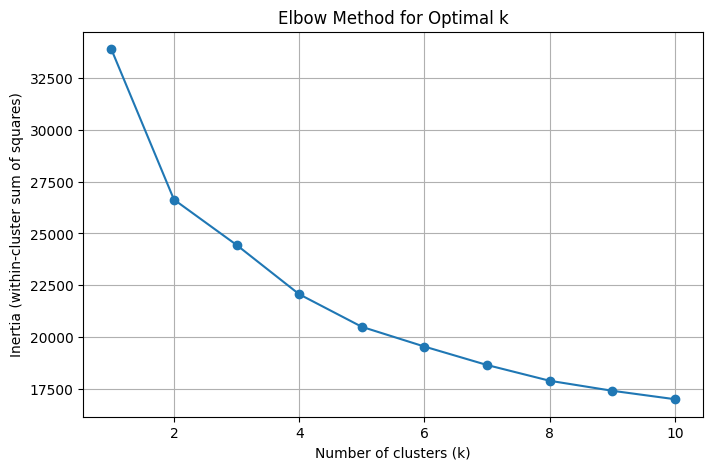

In [6]:
# create a list to store the inertia values
inertia = []

# run K-Means for a range of cluster values and compute the inertia for each
for k in range(1, 11):  # range from 1 to 10 clusters
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(df_transformed)  # fit on our transformed df
    inertia.append(kmeans.inertia_)  # append the inertia to the list

# plot the Elbow Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.grid(True)
plt.show()

### Model & Evaluation

Based on our elbow plot above, it looks like the ideal number of clusters will be somewhere between 3 and 7. We can evaluate the quality of our clusters by calculating the Silhouette Score. This score gives a measure of how well each point is clustered, considering both intra-cluster cohesion and inter-cluster separation. The score ranges from -1 to 1, with higher values indicating better clustering.

In [7]:
# loop through k=3 to k=6 to determine best # of clusters

# list to store silhouette scores for each value of k
silhouette_scores = {}

# loop through the desired number of clusters (3 to 6 in this case)
for k in range(3, 7):
    # fit K-Means with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_transformed)
    
    # calculate silhouette score
    sil_score = silhouette_score(df_transformed, cluster_labels)
    
    # store the score in the dictionary
    silhouette_scores[k] = sil_score
    #print(f'Number of clusters: {k}, Silhouette Score: {sil_score}') # print in each loop

#output all silhouette scores
print("\nSilhouette Scores for different cluster sizes:")
for k, score in silhouette_scores.items():
    print(f'{k} clusters: {score}')


Silhouette Scores for different cluster sizes:
3 clusters: 0.23342935939410084
4 clusters: 0.18189593841640625
5 clusters: 0.19217707908949094
6 clusters: 0.12302963175605883


In [11]:
# 3 clusters turned out to be best
kmeans = KMeans(n_clusters=3, random_state=42)

# assign cluster labels to the DataFrame
df_transformed['cluster'] = kmeans.fit_predict(df_transformed)

### PCA

Since we have to many features to easily visualize our clusters, we can use Principal Compnent Analysis to compress our features in to a 2D space.

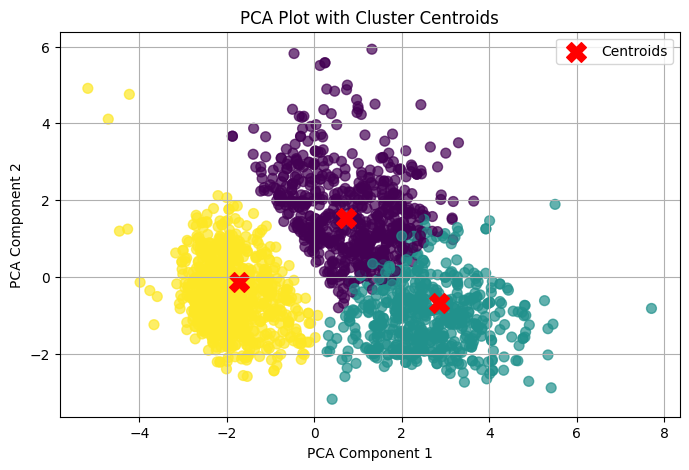

In [13]:
# apply PCA to reduce data to 2D
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_transformed)

# transform the cluster centers (centroids) into the reduced PCA space
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

# create the scatter plot for the data points
plt.figure(figsize=(8, 5))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df_transformed['cluster'], cmap='viridis', s=50, alpha=0.7)

# plot the cluster centroids as red X's
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, marker='X', label='Centroids')

# add titles and labels
plt.title('PCA Plot with Cluster Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# cluster counts
cluster_counts = df_transformed['cluster'].value_counts()
print(cluster_counts)

cluster
2    1027
0     637
1     576
Name: count, dtype: int64


In [48]:
# inverse transform numerical values for meaningful exploration below

# to access the fitted scaler, you can use preprocessor.named_transformers_['num']
fitted_numerical_transformer = preprocessor.named_transformers_['num']

# specify the numerical columns you want to inverse transform
columns_to_inverse_transform = df_transformed.filter(like='num_').columns.tolist()

# get the indices for these columns in the transformed DataFrame
num_column_indices = [df_transformed.columns.get_loc(f'{col}') for col in columns_to_inverse_transform]

# extract the transformed values for these columns
scaled_values = df_transformed.iloc[:, num_column_indices]

# inverse transform the scaled values using the numerical transformer
original_values = fitted_numerical_transformer.inverse_transform(scaled_values)

# create a DataFrame to hold the original values
original_df = pd.DataFrame(original_values, columns=columns_to_inverse_transform)

# combine with other columns from the original DataFrame
# get the original columns that are not inverse transformed
other_columns = df_transformed.drop(columns=columns_to_inverse_transform).copy()  # Keep only non-numerical columns

# concatenate original columns with the inverse transformed values
combined_df = pd.concat([other_columns.reset_index(drop=True), original_df.reset_index(drop=True)], axis=1)

# Rename columns to remove the prefix
combined_df.columns = combined_df.columns.str.replace('^num__', '', regex=True)
combined_df.columns = combined_df.columns.str.replace('^cat__', '', regex=True)

In [49]:
# replace var_explore with different fields to do a quikc comparison across our three clusters
combined_df.columns

Index(['relationship_status_current', 'relationship_status_previous',
       'relationship_status_single', 'education_lvl_high', 'education_lvl_low',
       'education_lvl_medium', 'cluster', 'Recency', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Complain', 'Response', 'income_clean',
       'customer_age', 'days_since_enroll', 'accepted_campaigns',
       'amount_spent', 'dependents'],
      dtype='object')

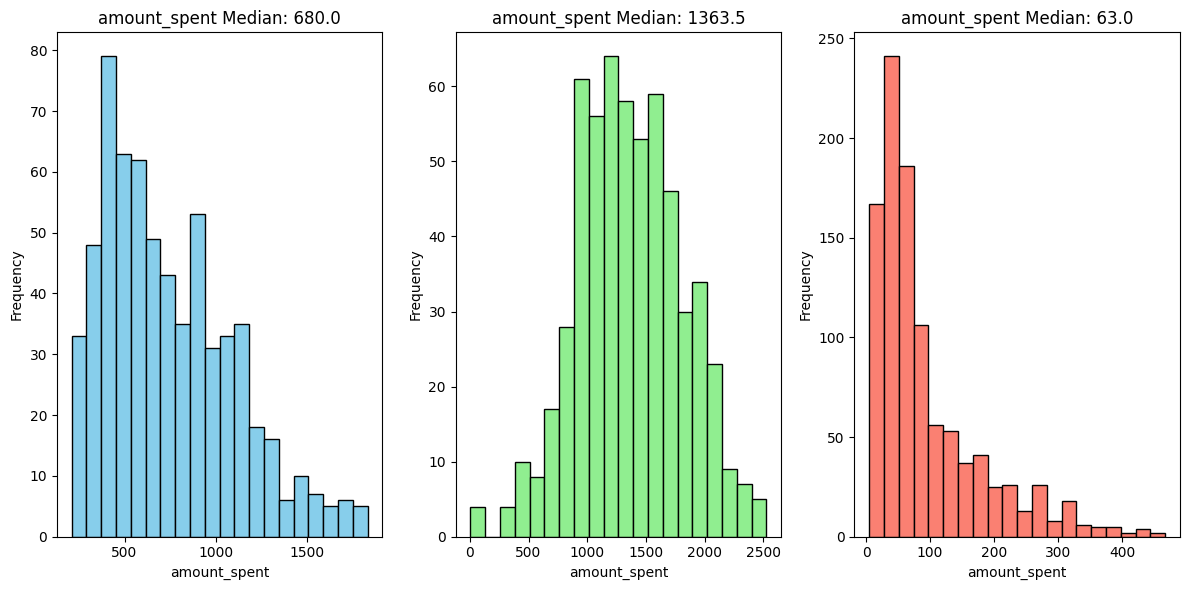

In [52]:
# which variable do you want to explore
# manually dynamic
var_explore = 'amount_spent'

# Plot histograms for the 'income' field for each cluster
plt.figure(figsize=(12, 6))

# Cluster 0
c0 = combined_df[combined_df['cluster'] == 0][var_explore].median()
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
plt.hist(combined_df[combined_df['cluster'] == 0][var_explore], bins=20, color='skyblue', edgecolor='black')
plt.title(f'{var_explore} Median: {c0}')
plt.xlabel(var_explore)
plt.ylabel('Frequency')

# Cluster 1
c1 = combined_df[combined_df['cluster'] == 1][var_explore].median()
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
plt.hist(combined_df[combined_df['cluster'] == 1][var_explore], bins=20, color='lightgreen', edgecolor='black')
plt.title(f'{var_explore} Median: {c1}')
plt.xlabel(var_explore)
plt.ylabel('Frequency')

# Cluster 2
c2 = combined_df[combined_df['cluster'] == 2][var_explore].median()
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
plt.hist(combined_df[combined_df['cluster'] == 2][var_explore], bins=20, color='salmon', edgecolor='black')
plt.title(f'{var_explore} Median: {c2}')
plt.xlabel(var_explore)
plt.ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Next Steps

Now that we have our customers clustered, we want to be able to leverage the insights gained and take actionable next steps. We can start by further profiling the groups. By analyzing the features of our clusters (income, spend, education, web purchases, etc.), we can more appropriately create profiles for each customer segment. We can assign meaningful labels/names based on what makes those groups unique (i.e. "High Spenders," "Budget-Conscious," or "Occasional Shoppers"). We can then use these profiles to tailor our marketing strategies, make custom product recommendations and optimize pricing strategies, among other things.